# **Tutorial**: Using the simulators `wt.SimA1C2`, `wt.SimA1C3` and `wt.SimA2C3`

[<<< Back to the simulator index](https://github.com/juangamella/causal-chamber-package/tree/main/causalchamber/simulators)

Other links:
- [Derivation of the simulators](https://arxiv.org/pdf/2404.11341#page=28&zoom=100,57,332)
- [Simulators source code](https://github.com/juangamella/causal-chamber-package/blob/main/causalchamber/simulators/wt/main.py)

If you use the simulators in your work, please consider citing:

```
﻿@article{gamella2025chamber,
  author={Gamella, Juan L. and Peters, Jonas and B{\"u}hlmann, Peter},
  title={Causal chambers as a real-world physical testbed for {AI} methodology},
  journal={Nature Machine Intelligence},
  doi={10.1038/s42256-024-00964-x},
  year={2025},
}
```

In [1]:
import sys
sys.path = ['../../..'] + sys.path

%load_ext autoreload
%autoreload 2

In [2]:
# IBM colorblind palette
palette = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]

## Dependencies

Besides the `causalchamber` package, the notebook also uses `matplotlib`, `numpy` and `pandas` (specified in `tutorials/requirements.txt`).

In [3]:
import causalchamber
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import gridspec


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or simulators for your work please consider citing:

﻿@article{gamella2025chamber,
  author={Gamella, Juan L. and Peters, Jonas and B{"u}hlmann, Peter},
  title={Causal chambers as a real-world physical testbed for {AI} methodology},
  journal={Nature Machine Intelligence},
  doi={10.1038/s42256-024-00964-x},
  year={2025},
}



## Initializing the simulators

We take the simulator parameters from calibration experiments and the technical specifications of the fans. See [this](https://github.com/juangamella/causal-chamber-paper/blob/main/case_studies/mechanistic_models.ipynb) notebook for the complete process.

In [1]:
# For model A1
C_MIN = 0.166
C_MAX = 0.27
L_MIN = 0.1
OMEGA_MAX = 3000

# For model A2
I = 3.481e-05
T = 0.05
K = 5.268701549401565e-08 # This is called "C" in the notebook linked above

#   Torque function (also a parameter for model A2)
def tau(L, C_min=C_MIN, C_max=C_MAX, L_min=L_MIN, T=T):
    L = np.atleast_1d(L)
    torques = T * (C_min + np.maximum(L_min, L) ** 3 * (C_max - C_min) - C_min)
    torques[L == 0] = 0
    return torques if len(L) > 1 else torques[0]

# For models C2 and C3
Q_MAX = 186.7 / 3600  # m3 / s
S_MAX = 74.82473949999999 # pascals
BETA = 0.15
R = 0.75
R_0 = 0.75

BAROMETER_ERROR = 0
BAROMETER_PRECISION = 0.2

Now we initialize the simulators with the above parameters:

In [5]:
import causalchamber.simulators.wt as wt

sim_a1c2 = wt.SimA1C2(
    # Parameters for model A1
    L_min=L_MIN,
    omega_max=OMEGA_MAX,
    # Parameters for model C2
    S_max=S_MAX,
    Q_max=Q_MAX,
    r=R,
    # Sensor noise
    barometer_error=BAROMETER_ERROR,  # The barometer offset
    barometer_precision=BAROMETER_PRECISION,  # The std. of the barometer sensor noise
    random_state=1,
)

sim_a1c3 = wt.SimA1C3(
    # Parameters for model A1
    L_min=L_MIN,
    omega_max=OMEGA_MAX,
    # Parameters for model C3
    S_max=S_MAX,
    Q_max=Q_MAX,
    r_0=R_0,
    beta=BETA,
    # Sensor noise
    barometer_error=BAROMETER_ERROR,  # The barometer offset
    barometer_precision=BAROMETER_PRECISION,  # The std. of the barometer sensor noise
    random_state=2,
)

sim_a2c3 = wt.SimA2C3(
    # Parameters for model A1    
    omega_max=OMEGA_MAX,
    I = I,
    tau = tau,
    K = K,
    omega_in_0 = L_MIN * OMEGA_MAX,
    omega_out_0 = L_MIN * OMEGA_MAX,
    # Parameters for model C3
    S_max=S_MAX,
    Q_max=Q_MAX,
    r_0=R_0,
    beta=BETA,
    # Sensor noise
    barometer_error=BAROMETER_ERROR,  # The barometer offset
    barometer_precision=BAROMETER_PRECISION,  # The std. of the barometer sensor noise
    random_state=3,
)

## Running the simulators

To simulate, call the function `.simulate_from_inputs` with a dataframe containing the simulator inputs as columns. There can be additional columns, which the simulator will ignore.

The names of the necessary columns can be obtained by calling:

In [6]:
sim_a1c2.inputs_names

['load_in', 'load_out', 'pressure_ambient']

In [7]:
sim_a1c3.inputs_names

['load_in', 'load_out', 'hatch', 'pressure_ambient']

### Example 1: Simulating from user-defined inputs

The simulators models the dynamics of the wind-tunnel pressure, given
- (all simulators) a time series of the fan loads (`load_in`, `load_out`) and the ambient pressure (`pressure_ambient`)
- (SimA1C3 and SimA2C3) hatch positions (`hatch`)
- timestamps at which the measurements happen (`timestamp`)


We will simulate what happens when we turn the intake load on (`load_in=1`) and off (`load_in=0`) in a short impulse, while keeping the exhaust load (`load_out`) constant and opening the hatch half-way through the impulse.

In [8]:
inputs = pd.DataFrame({'load_in': np.array([0] * 30 + [1] * 40 + [0] * 30),                       
                       'load_out': [0.1] * 100,
                       'timestamp': np.linspace(0,10,100),
                       'hatch': np.array([0] * 50 + [45] * 50),
                       'pressure_ambient': 0})
outputs_a1c2 = sim_a1c2.simulate_from_inputs(inputs)
outputs_a1c3 = sim_a1c3.simulate_from_inputs(inputs)
outputs_a2c3 = sim_a2c3.simulate_from_inputs(inputs)

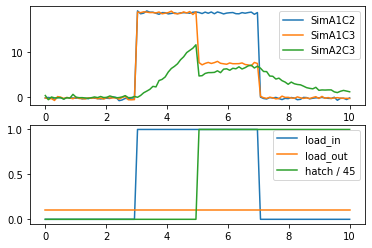

In [9]:
plt.subplot(211)
plt.plot(inputs.timestamp, outputs_a1c2[0], label="SimA1C2")
plt.plot(inputs.timestamp, outputs_a1c3[0], label="SimA1C3")
plt.plot(inputs.timestamp, outputs_a2c3[0], label="SimA2C3")
plt.legend()
plt.xlabel("Time (s)")

plt.subplot(212)
plt.plot(inputs.timestamp, inputs.load_in, label="load_in")
plt.plot(inputs.timestamp, inputs.load_out, label="load_out")
plt.plot(inputs.timestamp, inputs.hatch / 45, label="hatch / 45")
plt.legend()

### Example 2: Comparing to real measurements

We download a dataset of real measurements using the functionality provided in the `causalchamber` package. The downloaded dataset is stored in the path given by `root=` below.

For our experiment we will use the `wt_test_v1` dataset, which is described [here](https://github.com/juangamella/causal-chamber/tree/main/datasets/wt_test_v1).

In [10]:
# Download the dataset
dataset = causalchamber.datasets.Dataset('wt_test_v1', root='./', download=True)

# Load the "steps" experiment
experiment = dataset.get_experiment(name='steps')
observations = experiment.as_pandas_dataframe().iloc[0:200]

Dataset wt_test_v1 found in "wt_test_v1".


We will compare our simulator with the behaviour of the intake fan in the above experiment.

First, let us create the inputs for all three simulators.

In [11]:
inputs = observations[['load_in', 'load_out', 'hatch', 'timestamp', 'pressure_ambient']]

outputs_a1c2 = sim_a1c2.simulate_from_inputs(inputs)
outputs_a1c3 = sim_a1c3.simulate_from_inputs(inputs)
outputs_a2c3 = sim_a2c3.simulate_from_inputs(inputs)

**Plot the results**: real vs. simulated measurements of the fan speeds and downwind pressure measurement

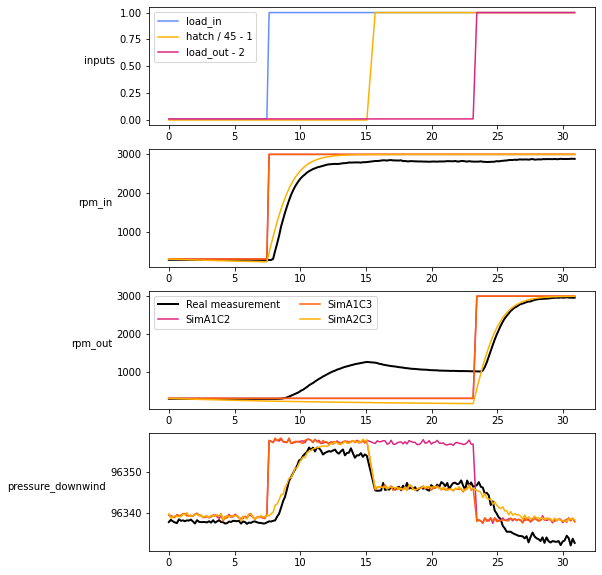

In [12]:
plt.figure(figsize=(8,10))
t = observations.timestamp - observations.timestamp.iloc[0]

# Plot inputs (loads and hatch)
plt.subplot(411)
plt.plot(t, inputs.load_in, color=palette[0], label="load_in")
plt.plot(t, inputs.hatch / 45, color=palette[4], label="hatch / 45 - 1")
plt.plot(t, inputs.load_out, color=palette[2], label="load_out - 2")
plt.ylabel("inputs", rotation=0, ha="right")
plt.legend()

# Plot simulated rpm_in
plt.subplot(412)
plt.ylabel("rpm_in", rotation=0, ha="right")
plt.plot(t, observations.rpm_in, color='black', label="Real measurement", linewidth=2)
plt.plot(t, outputs_a1c2[1], color=palette[2], label="SimA1C2")
plt.plot(t, outputs_a1c3[1], color=palette[3], label="SimA1C3")
plt.plot(t, outputs_a2c3[1], color=palette[4], label="SimA2C3")

# Plot simulated rpm_out
plt.subplot(413)
plt.ylabel("rpm_out", rotation=0, ha="right")
plt.plot(t, observations.rpm_out, color='black', label="Real measurement", linewidth=2)
plt.plot(t, outputs_a1c2[2], color=palette[2], label="SimA1C2")
plt.plot(t, outputs_a1c3[2], color=palette[3], label="SimA1C3")
plt.plot(t, outputs_a2c3[2], color=palette[4], label="SimA2C3")
plt.legend(ncol=2, loc="upper left")

# Plot simulated pressure_downwind
plt.subplot(414)
plt.ylabel("pressure_downwind", rotation=0, ha="right")
plt.plot(t, observations.pressure_downwind, color='black', label="Real measurement", linewidth=2)
plt.plot(t, outputs_a1c2[0], color=palette[2], label="SimA1C2")
plt.plot(t, outputs_a1c3[0], color=palette[3], label="SimA1C3")
plt.plot(t, outputs_a2c3[0], color=palette[4], label="SimA2C3")

Above we plot the output of the simulators (fan speeds + downwind pressure measurement) vs. the real measurements, in black, collected from the wind tunnel.

Because the fans are modelled as independent, the simulators do not capture the coupling between their speeds, e.g., in the third panel (rpm_out).